In [1]:
import tensorflow as tf
import os, sys
import numpy as np
from matplotlib import pyplot as plt
layers = tf.contrib.layers

In [2]:
data_generator = os.environ['DATA_GENERATOR']
sys.path.append(data_generator)
import get_data
from visualization import Visualizer

autoencoder

In [3]:
#     def _build_graph(self, input, dim_code, reuse=tf.AUTO_REUSE, training=False):
#         regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
#         net = layers.conv2d(input, 128, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.flatten(net)
#         net = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
#         #net = layers.fully_connected(net, 7*7, weights_regularizer=regularizer)
#         net = tf.reshape(shape=[-1, 7, 7, 1], tensor=net)
#         net = layers.conv2d_transpose(net, 64, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 128, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 1, (3,3), 1, activation_fn=tf.nn.tanh, weights_regularizer=regularizer)
#         return net

variational autoencoder

In [4]:
#     def _build_graph(self, input, dim_code, reuse=tf.AUTO_REUSE, training=False):
#         regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
#         net = layers.conv2d(input, 128, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.flatten(net)
        
#         z_mu = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
#         z_logvar = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
#         epsilon = tf.random_normal(tf.shape(z_logvar), name='epsilon')
#         z_std = tf.sqrt(tf.exp(z_logvar))
#         latent_var = z_mu + epsilon*z_std
        
#         net = layers.fully_connected(latent_var, 7*7, weights_regularizer=regularizer)
#         net = tf.reshape(shape=[-1, 7, 7, 1], tensor=net)
#         net = layers.conv2d_transpose(net, 64, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 128, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 1, (3,3), 1, activation_fn=tf.nn.tanh, weights_regularizer=regularizer)
#         return net

In [5]:
class VAE():
    def __init__(self):
        self.graph = tf.Graph()
        self.batch_size = 128
        with self.graph.as_default():
            with tf.device('/cpu:0'):
                self.images, labels = get_data.data_pipeline('mnist', 128, 'train')
            self.visualizer = Visualizer(exp_name='VAE_mnist', row=8, col=8)
            self.generated_images, z_mu, z_std = self._build_graph(self.images, 8, reuse=tf.AUTO_REUSE, training=True)
            self.recon_loss = self._recon_loss_function(self.images, self.generated_images)
            self.kld_loss = self._kld_loss_function(z_mu, z_std)
            self.loss = tf.reduce_mean(self.recon_loss + self.kld_loss)
            self.solver = tf.train.AdamOptimizer(learning_rate=0.0001) \
                           .minimize(self.loss)
            initializer = tf.global_variables_initializer()
            self.sess = tf.Session()
            self.sess.run(initializer)
    def train(self, iteration):
        for i in range(iteration+1):
            loss, recon_loss, kld_loss, _, np_real_images, np_generated_images = self.sess.run(
                    [self.loss, self.recon_loss, self.kld_loss, self.solver, self.images, self.generated_images])
            if i % 10 == 0:
                print("iterator {} : loss {:.3} = kld {:.3} + recon {:.3} ".format(i, loss, kld_loss, recon_loss))
            if i % 1000 == 0:
                self.visualize(np_real_images, np_generated_images, i)
            
    def visualize(self, images, generated_images, i):
        visual_imgs = np.concatenate( (images[:8*4], generated_images[:8*4]), axis = 0 )
        visual_imgs = 255*(visual_imgs/2 + 0.5)
        visual_imgs = visual_imgs.astype(int)
        self.visualizer.draw_imgs(visual_imgs)
        self.visualizer.save_fig(name="VAE_mnist_iter_{}".format(str(i)))
        
    def _build_graph(self, input, dim_code, reuse=tf.AUTO_REUSE, training=False):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        net = layers.conv2d(input, 128, (3,3), 1, weights_regularizer=regularizer)
        net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
        net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
        net = layers.flatten(net)
        net = layers.fully_connected(net, 128, weights_regularizer=regularizer)
        z_mu = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
        z_logvar = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
        epsilon = tf.random_normal(tf.shape(z_logvar), name='epsilon')
        z_std = tf.sqrt(tf.exp(z_logvar))
        latent_var = z_mu + epsilon*z_std
        net = layers.fully_connected(latent_var, 128, weights_regularizer=regularizer)
        net = layers.fully_connected(net, 7*7*32, weights_regularizer=regularizer)
        net = tf.reshape(shape=[-1, 7, 7, 32], tensor=net)
        net = layers.conv2d_transpose(net, 64, (3,3), 1, weights_regularizer=regularizer)
        net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer)
        net = layers.conv2d_transpose(net, 128, (3,3), 2, weights_regularizer=regularizer)
        net = layers.conv2d_transpose(net, 1, (3,3), 1, activation_fn=tf.nn.tanh, weights_regularizer=regularizer)
        return net, z_mu, z_std
    def _recon_loss_function(self, _real_images, _generated_images):
        recon_loss = tf.reduce_sum(tf.square(_real_images - _generated_images))
        return recon_loss
    def _kld_loss_function(self, z_mu, z_std):
        #KLD_loss = -0.5 * tf.reduce_mean(1 + z_std - tf.pow(z_mu, 2) - tf.exp(z_std))
        KLD_loss = -0.5 * tf.reduce_sum(1 -tf.square(z_mu) -tf.square(z_std) + tf.log(1e-8 + tf.square(z_std)))
        return KLD_loss
    def close(self):
        self.sess.close()

(?, 28, 28, 1)


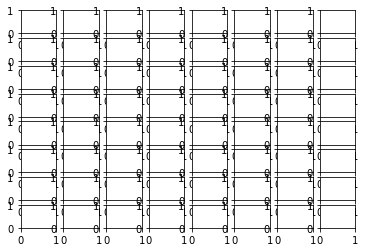

In [6]:
x = VAE()

In [7]:
x.train(iteration=20000)
x.close()

iterator 0 : loss 8.6e+04 = kld 0.639 + recon 8.6e+04 
iterator 10 : loss 8.31e+04 = kld 54.1 + recon 8.3e+04 
iterator 20 : loss 7.38e+04 = kld 1.63e+03 + recon 7.21e+04 
iterator 30 : loss 5.71e+04 = kld 3.48e+03 + recon 5.36e+04 
iterator 40 : loss 4.89e+04 = kld 2.45e+03 + recon 4.65e+04 
iterator 50 : loss 4.15e+04 = kld 6.8e+02 + recon 4.08e+04 
iterator 60 : loss 3.56e+04 = kld 7e+02 + recon 3.49e+04 
iterator 70 : loss 3.57e+04 = kld 4.13e+02 + recon 3.52e+04 
iterator 80 : loss 3.49e+04 = kld 4.97e+02 + recon 3.44e+04 
iterator 90 : loss 3.2e+04 = kld 5.67e+02 + recon 3.15e+04 
iterator 100 : loss 3.1e+04 = kld 6.71e+02 + recon 3.04e+04 
iterator 110 : loss 2.86e+04 = kld 8.19e+02 + recon 2.78e+04 
iterator 120 : loss 2.61e+04 = kld 8.49e+02 + recon 2.53e+04 
iterator 130 : loss 2.76e+04 = kld 6.97e+02 + recon 2.69e+04 
iterator 140 : loss 2.58e+04 = kld 6.79e+02 + recon 2.51e+04 
iterator 150 : loss 2.83e+04 = kld 5.01e+02 + recon 2.78e+04 
iterator 160 : loss 2.57e+04 = kld 

iterator 1330 : loss 2.01e+04 = kld 2.19e+03 + recon 1.79e+04 
iterator 1340 : loss 1.8e+04 = kld 2.38e+03 + recon 1.57e+04 
iterator 1350 : loss 1.86e+04 = kld 2.1e+03 + recon 1.65e+04 
iterator 1360 : loss 1.91e+04 = kld 2.11e+03 + recon 1.7e+04 
iterator 1370 : loss 1.9e+04 = kld 2.33e+03 + recon 1.67e+04 
iterator 1380 : loss 1.87e+04 = kld 2.01e+03 + recon 1.67e+04 
iterator 1390 : loss 1.88e+04 = kld 2.05e+03 + recon 1.67e+04 
iterator 1400 : loss 2.05e+04 = kld 2.12e+03 + recon 1.84e+04 
iterator 1410 : loss 1.93e+04 = kld 2.06e+03 + recon 1.73e+04 
iterator 1420 : loss 1.9e+04 = kld 2.44e+03 + recon 1.65e+04 
iterator 1430 : loss 1.91e+04 = kld 2.1e+03 + recon 1.7e+04 
iterator 1440 : loss 2.01e+04 = kld 2.22e+03 + recon 1.78e+04 
iterator 1450 : loss 1.93e+04 = kld 2.46e+03 + recon 1.69e+04 
iterator 1460 : loss 1.75e+04 = kld 2.28e+03 + recon 1.53e+04 
iterator 1470 : loss 2e+04 = kld 2.06e+03 + recon 1.79e+04 
iterator 1480 : loss 2.05e+04 = kld 2.09e+03 + recon 1.84e+04 
it

iterator 2650 : loss 1.77e+04 = kld 2.5e+03 + recon 1.52e+04 
iterator 2660 : loss 1.86e+04 = kld 2.3e+03 + recon 1.63e+04 
iterator 2670 : loss 1.85e+04 = kld 2.59e+03 + recon 1.6e+04 
iterator 2680 : loss 1.77e+04 = kld 2.91e+03 + recon 1.48e+04 
iterator 2690 : loss 1.89e+04 = kld 2.24e+03 + recon 1.67e+04 
iterator 2700 : loss 1.71e+04 = kld 2.22e+03 + recon 1.49e+04 
iterator 2710 : loss 1.82e+04 = kld 2.38e+03 + recon 1.58e+04 
iterator 2720 : loss 1.94e+04 = kld 2.56e+03 + recon 1.68e+04 
iterator 2730 : loss 1.9e+04 = kld 2.12e+03 + recon 1.68e+04 
iterator 2740 : loss 1.82e+04 = kld 2.83e+03 + recon 1.54e+04 


KeyboardInterrupt: 

https://github.com/dancsalo/TensorFlow-VAE